In [43]:
from __future__ import division
import numpy as np
import pandas as pd
from skbio.stats.composition import ilr, ilr_inv, perturb, perturb_inv

from skbio import TreeNode
from canvas.phylogeny import phylogenetic_basis
from biom import load_table

import random
from ete3 import Tree, TreeStyle, NodeStyle, faces, AttrFace, CircleFace, BarChartFace
%matplotlib inline

In [44]:
table = pd.DataFrame({'a':[10, 10], 'b':[10, 10], 
                      'c':[10, 10], 'd':[20, 40]})
mapping = pd.Series(['Control', 'Treatment'])
tree = TreeNode.read([u"((a,b)f, (c,d)g)r;"])

In [45]:
def layout(node):
    if node.is_leaf():
        # Add node name to leaf nodes
        N = AttrFace("name", fsize=18, fgcolor='black')
        
        faces.add_face_to_node(N, node, 0)
    if "weight" in node.features:
        # Creates a sphere face whose size is proportional to node's
        # feature "weight"
        C = BarChartFace(values=node.weight, width=20, height=40, 
                         colors=['#FF0000','#0000FF'], min_value=0, max_value=1)
        # Let's make the sphere transparent
        C.opacity = 0.3
        
        # And rotate the face by 90 degrees
        C.rotation = 90
        # And place as a float face over the tree
        faces.add_face_to_node(C, node, 0, position="float")
        
def build_ete_diff_abundance(sk_tree, ilr_df, mapping):
    """
    Parameters
    ----------
    sk_tree : skbio.TreeNode
        Scikit bio tree node data structure
    ilr_df : pd.DataFrame
        DataFrame of ilr coordinates.
    category : pd.Series
        DataFrame of mapping file
    """
    # The names aren't preserved - let's pray that the topology is consistent.
    ete_tree = Tree(str(sk_tree), format=1)    
    cats = set(mapping)
    # Some random features in all nodes
    i = 0
    for n in ete_tree.traverse():
        if not n.is_leaf():
            x = [np.mean(ilr_coords[(mapping==cat).values, i]) for cat in cats] 
            n.add_features(weight=x)
            i += 1
    # Create an empty TreeStyle
    ts = TreeStyle()

    # Set our custom layout function
    ts.layout_fn = layout

    # Draw a tree
    #ts.mode = "c"

    # We will add node names manually
    ts.show_leaf_name = False
    # Show branch data
    ts.show_branch_length = True
    ts.show_branch_support = True

    return ete_tree, ts

In [46]:
sorted_otus = [n.name for n in tree.levelorder() if n.is_tip()]
table = table.reindex_axis(sorted_otus, axis=1)

In [47]:
basis, nodes = phylogenetic_basis(tree)
ilr_coords = ilr(table, basis=basis) 

In [48]:
tr, ts = build_ete_diff_abundance(tree, ilr_coords, mapping) 

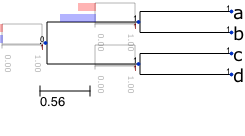

In [49]:
tr.render(file_name='%%inline', tree_style=ts)